# MAE

In [1]:
%cd ~/Documents/TESI/TESI/notebooks
%load_ext autoreload
%autoreload 2

/home/zano/Documents/TESI/TESI/notebooks


/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import re
import tifffile
import glob
import random
import torch
import pytorch_lightning as pl
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from configs.ConfigLoader import ConfigLoader
from utils.train_functions import (
# train_epoch,
# val_epoch,
# print_model_summary,
# plot_cv_results,
# train_epoch_mixUp,
# print_layers,
# oversample_minority,
# undersample_majority,
# freeze_layers_up_to,
# freeze_layers_up_to_progressive_ft,
train_epoch_vit,
val_epoch_vit,
)

import utils.transformations_functions as tf
# Removed redundant import: from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
# import torch.nn.functional as F
# from monai.visualize.class_activation_maps import GradCAMpp,GradCAM  
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False:


2.6.0+cu124
1.4.0


In [3]:
from utils.setup_functions import set_environment_flags
# Example usage:
environment_flags = set_environment_flags()
kaggle,gdrive,linux = environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"]
from utils.reproducibility_functions import set_global_seed
set_global_seed(42)

Environment settings: {'gdrive': False, 'linux': True, 'kaggle': False, 'ssl': True}


In [4]:
# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui(tracking_uri) # start mlflow ui

you are on linux
Linux detected, setting tracking URI
Final Tracking URI: /home/zano/Documents/TESI/mlruns
Does the directory exist? True


In [5]:
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))
from utils.directory_functions import get_data_and_base_directory
data_dir, base_dir = get_data_and_base_directory(environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"], num_input_channels=num_input_channels)

3 channels input
you are in linux
/home/zano/Documents/TESI/3c_MIP_new


# DATA EXTRACTION

In [6]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [7]:
## Paths of ALL images into a numpy array without labels used for SSL
def from_tif_folder_to_np_paths_array(folder_path: str) -> np.ndarray:
    """
    Load all .tif images from a folder into a numpy array.
    """
    image_paths = glob.glob(os.path.join(folder_path, "*.tif"))
    image_paths_np = np.array(image_paths)
    print(f"Number of images in {folder_path}: {len(image_paths)}")
    return image_paths_np

all_images_folder_path = os.path.join(data_dir, "ALL")
all_images_paths = from_tif_folder_to_np_paths_array(all_images_folder_path)
print("Number of images in ALL folder:", len(all_images_paths))

Number of images in /home/zano/Documents/TESI/3c_MIP_new/ALL: 152
Number of images in ALL folder: 152


In [8]:
## Paths of ALL images into a numpy array without labels used for SSL
print(class_names)
if class_names == ['MSA-P', 'PD']:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL+MSA-C")
else:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL")
    

ssl_images_paths_np = from_tif_folder_to_np_paths_array(ssl_images_folder_path)
print(f"Number of images in {ssl_images_folder_path} folder:", len(ssl_images_paths_np))

['MSA', 'PD']
Number of images in /home/zano/Documents/TESI/3c_MIP_new/CONTROL: 19
Number of images in /home/zano/Documents/TESI/3c_MIP_new/CONTROL folder: 19


{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
Class directories:
{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
MSA images (before filtering): 'gh' count: 83, 'vaso' count: 0
Number of glandular images before filtering: 83
Number of glandular images after filtering: 83
PD images (before filtering): 'gh' count: 57, 'vaso' count: 0
Number of glandular images before filtering: 57
Number of glandular images after filtering: 57


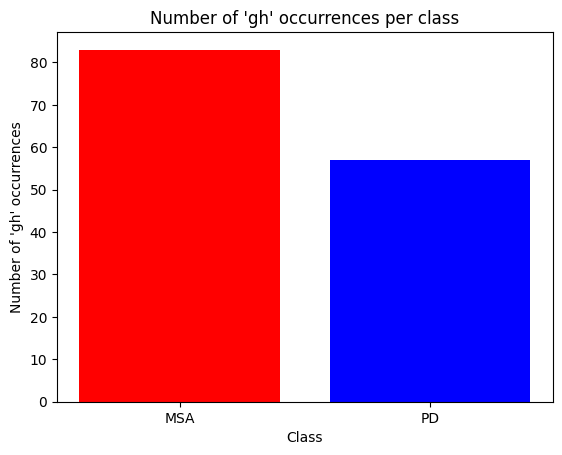


Checking image shapes:
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh2.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5463 gh.tif.tif  dt

In [9]:
# Create a dictionary mapping each class to its directory
class_dirs = {} # { "class_name": "path/to/class_dir", "class_name2": "path/to/class_dir2", ... }
is_three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if is_three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    from utils.data_extraction_functions import remove_non_gland_images
    image_paths = remove_non_gland_images(image_paths)
    # counts after filtering
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    # print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
# def plot_counts_bar_chart(counts_dict, class_names):
#     """
#     Plot a bar chart of counts for each class.
#     """
#     plt.figure(figsize=(10, 6))
#     plt.bar(class_names, [counts_dict[cn]["gh_count"] for cn in class_names], color='blue')
#     plt.xlabel("Class")
#     plt.ylabel("Number of 'gh' occurrences")
#     plt.title("Number of 'gh' occurrences per class")
#     plt.show()

plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
# random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts.keys(), key=lambda k: counts[k])
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

Original dataset size: 140
Original label distribution: {0: 83, 1: 57}

Aiming for a balanced test set with 57 samples per class.
Total balanced test set size will be: 114
Test set size: 114

Test set distribution: {0: 57, 1: 57}


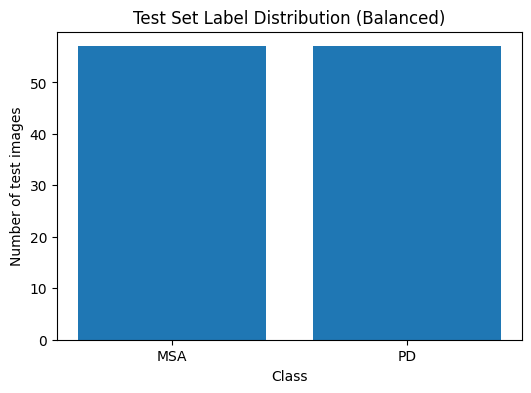


Test set counts and percentages:
MSA: 57 images (50.0% of test set)
PD: 57 images (50.0% of test set)


In [10]:
# --- Your Split Logic for 50/50 distribution in test set ---
print("Original dataset size:", len(images_paths_np))

# Find unique labels and their counts in the original dataset
unique_labels, counts = np.unique(labels_np, return_counts=True)
original_distribution = dict(zip(unique_labels, counts))
print(f"Original label distribution: {original_distribution}")

# Determine the maximum possible size for a balanced test set per class
# This is limited by the count of the smallest class
if len(unique_labels) > 1:
    min_class_count = min(counts)
    # We want a balanced test set, so take 'min_class_count' samples from each class
    test_samples_per_class = min_class_count
    total_balanced_test_size = test_samples_per_class * len(unique_labels)

    print(f"\nAiming for a balanced test set with {test_samples_per_class} samples per class.")
    print(f"Total balanced test set size will be: {total_balanced_test_size}")

    test_indices = []
    train_indices = []

    # Iterate through each class to split
    for label in unique_labels:
        # Get the indices in the original array that correspond to the current class
        # print ( labels_np == label) # returns a boolean array
        class_indices = np.where(labels_np == label)[0]  #use the boolean array to get the indices where cond is true 
        # print(f"\nClass {label} indices: {class_indices}") #retuns the indices of the class in the original array and the boolarray so we use [0] to get the indices

        # Randomly select a fixed number of indices for the test set from this class
        # Use np.random.choice with replace=False for sampling without replacement
        # Set a random_state for reproducibility if needed
        rng = np.random.default_rng(42) # Use new random generator recommended over np.random.seed
        test_class_indices = rng.choice(
            class_indices,
            size=test_samples_per_class,
            replace=False
        )
        test_indices.extend(test_class_indices)

    # Convert lists of indices to NumPy arrays
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)

    # Shuffle the indices to mix up the classes in the final arrays (optional but good practice)
    # rng.shuffle(test_indices)
    # rng.shuffle(train_indices)

    balanced_test_images_paths = images_paths_np[test_indices]
    balanced_test_true_labels = labels_np[test_indices]
    print(f"Test set size: {len(balanced_test_images_paths)}")

    # Verify the test set distribution
    test_unique_labels, test_counts = np.unique(balanced_test_true_labels, return_counts=True)
    test_distribution = dict(zip(test_unique_labels, test_counts))
    print(f"\nTest set distribution: {test_distribution}")


    plt.figure(figsize=(6, 4))
    # Use test_unique_labels and test_counts for the bar plot
    labels_for_plot = [class_names[label] if 'class_names' in locals() else f"Label {label}" for label in test_unique_labels]
    plt.bar(labels_for_plot, test_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of test images")
    plt.title("Test Set Label Distribution (Balanced)")
    plt.show()

    # Print counts and percentages for the balanced test set
    print("\nTest set counts and percentages:")
    for label, count in zip(test_unique_labels, test_counts):
         class_name = class_names[label] if 'class_names' in locals() else f"Label {label}"
         print(f"{class_name}: {count} images ({count/len(balanced_test_true_labels):.1%} of test set)")

else:
    print("Cannot perform a balanced split with less than two unique classes.")

119 training images
21 test images
<class 'numpy.ndarray'>


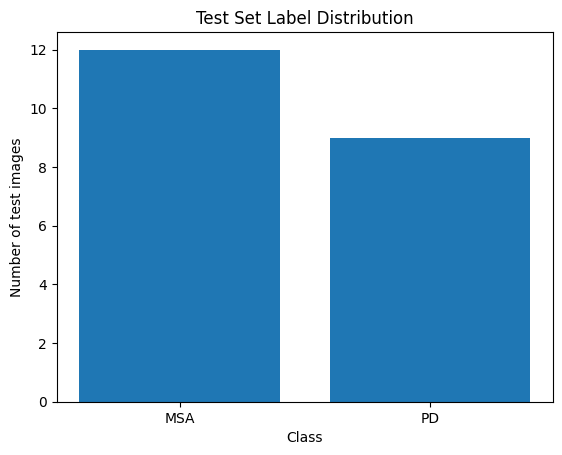

Label 0 (MSA): 12 images
Label 1 (PD): 9 images
Label 0 (MSA) is: 0.5714285714285714
Label 1 (PD) is: 0.42857142857142855


In [11]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size= 0.15,
    stratify=labels,
    random_state=42,
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
# print("train images paths:", train_images_paths)
# print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
# print(test_images_paths)
print(type(train_images_paths))

unique_labels, counts = np.unique(test_true_labels_np, return_counts=True)


plt.bar([class_names[label] for label in unique_labels], counts)
plt.xlabel("Class")
plt.ylabel("Number of test images")
plt.title("Test Set Label Distribution")
plt.show()

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}): {count} images")

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}) is: {count/test_true_labels_np.shape[0]}")

In [ ]:
## Paths of ALL images into a numpy array without labels used for SSL
print(class_names)
if class_names == ['MSA-P', 'PD']:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL+MSA-C")
else:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL")
    
ssl_images_paths = glob.glob(os.path.join(ssl_images_folder_path, "*.tif"))
ssl_images_paths_np = np.array(ssl_images_paths)
print("Number of images in ALL folder:", len(ssl_images_paths))

In [12]:
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id)

display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str)

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first()

unique_pat_ids = patient_label_df["patient_id"].values  # need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

patient_label_df

,image_path,label,patient_id
0,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4092
1,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4092
2,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4121
3,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4121
4,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_5...,0,5358
...,...,...,...
135,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_74...,1,7461
136,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_75...,1,7544
137,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...,1,7677
138,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...,1,7688


Unique patient IDs: ['4092' '4121' '5358' '5435' '5463' '5717' '5745' '5753' '5767' '5776'
 '5878' '5881' '5904' '5954' '5969' '5978' '5992' '5996' '6008' '6046'
 '6053' '6060' '6085' '6179' '6308' '6311' '6320' '6323' '6326' '6337'
 '6340' '6351' '6363' '6366' '6375' '6383' '6424' '6427' '6459' '6485'
 '6491' '6571' '6577' '6593' '6599' '6616' '6651' '6657' '6663' '6690'
 '6696' '6749' '6773' '6791' '7105' '7120' '7132' '7144' '7155' '7179'
 '7185' '7191' '7222' '7229' '7239' '7284' '7293' '7343' '7461' '7544'
 '7579' '7677' '7688' '7710']
Number of unique patients: 74
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1]


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
69,7544,1
70,7579,0
71,7677,1
72,7688,1


In [ ]:
# ## MAE
# %pip install "lightly[timm]" pytorch-lightning torch torchvision
# %pip install --upgrade timm
from lightly.utils import dependency as _dependency
print(_dependency.timm_vit_available())
from configs.ConfigLoader import ConfigLoader
from torch.utils.data import DataLoader
import utils.transformations_functions as tf
# Removed redundant import: from configs.ConfigLoader import ConfigLoader
import numpy as np
from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/vit.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "monai" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")
# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
print(model)
print(cfg.get_model_input_channels())

###########################################################
# mae_lightning_example.py
# Example script for Masked Autoencoder (MAE) pre-training using PyTorch Lightning,
# Lightly (for data handling and transforms), and TIMM (for ViT models).
# Installation: pip install "lightly[timm]" pytorch-lightning torch torchvision timm
###########################################################
import pytorch_lightning as pl
import torch
from timm.models.vision_transformer import vit_base_patch32_224 # Base Vision Transformer model from TIMM
from torch import nn
# from torch.utils.data import DataLoader
# Lightly imports
from lightly.data import LightlyDataset                        
from lightly.transforms.mae_transform import MAETransform                    # Specific data transforms for MAE
from lightly.models import utils                             # Helper utilities (e.g., masking)
from lightly.models.modules import MAEDecoderTIMM, MaskedVisionTransformerTIMM # MAE-specific encoder and decoder modules

###########################################################
# 1) Callback to Print Epoch Loss
###########################################################
class PrintEpochLossCallback(pl.Callback):
    """
    A simple PyTorch Lightning Callback that prints the average 'train_loss'
    logged during the epoch to the console after each training epoch finishes.
    Useful for quick monitoring when a full progress bar is disabled.
    """
    def on_train_epoch_end(self, trainer, pl_module):
        # Access metrics logged during the epoch via the trainer
        epoch_loss = trainer.callback_metrics.get("train_loss")
        current_epoch = trainer.current_epoch
        if epoch_loss is not None:
            # Print formatted loss
            print(f"[Epoch {current_epoch}] => train_loss: {epoch_loss:.4f}")
        else:
            # Handle case where loss might not have been logged (e.g., first epoch sanity check)
            print(f"[Epoch {current_epoch}] => train_loss not found in metrics")

###########################################################
# 2) MAE LightningModule Definition
###########################################################
class MAE(pl.LightningModule):
    """
    Implementation of the Masked Autoencoder (MAE) self-supervised learning strategy
    using a Vision Transformer (ViT) backbone from TIMM.

    The core idea is to:
    1. Randomly mask a large portion of input image patches.
    2. Feed only the *visible* (unmasked) patches to the ViT encoder.
    3. Use a lightweight decoder to reconstruct the *original pixels* of the *masked* patches
       based on the encoded representations of the visible patches and learnable mask tokens.
    """

    def __init__(self, mask_ratio: float = 0.75):
        """
        Initializes the MAE model components.

        Args:
            mask_ratio: The fraction of input image patches to randomly mask (hide) during training.
                        Defaults to 0.75 (75%), as used in the original MAE paper.
        """
        super().__init__()
        self.save_hyperparameters() # Saves mask_ratio to hparams

        # --- Encoder Setup ---
        # Load a pre-defined Vision Transformer base model from TIMM library.
        # vit_base_patch32_224: Base-sized ViT, 32x32 patches, expects 224x224 input.
        # Note: weights are not loaded here; we train from scratch or load MAE pre-trained later.
        vit = vit_base_patch32_224(pretrained=False) # Start from scratch for pre-training
        self.patch_size = vit.patch_embed.patch_size[0]

        # Wrap the TIMM ViT with Lightly's MaskedVisionTransformerTIMM.
        # This wrapper allows the ViT encoder to process only a subset of patch tokens (the visible ones).
        self.backbone = MaskedVisionTransformerTIMM(vit=vit)

        # Store the sequence length (number of patches + each with a class token)
        self.sequence_length = self.backbone.sequence_length

        # --- Decoder Setup ---
        # Create the MAE decoder module. It's typically much smaller/shallower than the encoder.
        self.decoder = MAEDecoderTIMM(
            num_patches=vit.patch_embed.num_patches, # Total number of patches (e.g., 49)
            patch_size=self.patch_size,              # Patch size (e.g., 32)
            embed_dim=vit.embed_dim,                 # Encoder's embedding dimension (e.g., 768 for ViT-Base)
            decoder_embed_dim=512,                   # Decoder's embedding dimension (can be smaller)
            decoder_depth=1,                         # Number of transformer blocks in the decoder (shallow)
            decoder_num_heads=16,                    # Number of attention heads in the decoder
            mlp_ratio=4.0,                           # MLP expansion ratio in decoder blocks
            proj_drop_rate=0.0,                      # Dropout rates (often disabled in decoder)
            attn_drop_rate=0.0,
        )

        # --- Loss Function ---
        # MAE reconstructs raw pixel values of the masked patches.
        # Mean Squared Error (MSE) loss is used to measure the reconstruction quality.
        self.criterion = nn.MSELoss()

    def forward_encoder(self, images: torch.Tensor, idx_keep: torch.Tensor = None) -> torch.Tensor:
        """
        Runs the forward pass through the MAE encoder (ViT backbone).

        Args:
            images: Batch of input images (B, C, H, W).
            idx_keep: Tensor containing the indices of the patches to *keep* (process).
                      If None, all patches are processed. Shape: (B, num_kept_patches).

        Returns:
            Tensor containing the encoded representations of the kept patches.
            Shape: (B, num_kept_patches, encoder_embed_dim).
        """
        return self.backbone.encode(images=images, idx_keep=idx_keep)

    def forward_decoder(self, x_encoded: torch.Tensor, idx_keep: torch.Tensor, idx_mask: torch.Tensor) -> torch.Tensor:
        """
        Runs the forward pass through the MAE decoder to reconstruct masked patches.

        Args:
            x_encoded: Encoded representations of the visible patches from the encoder.
                       Shape: (B, num_kept_patches, encoder_embed_dim).
            idx_keep: Indices of the patches that were *kept* (visible) by the encoder.
                      Shape: (B, num_kept_patches).
            idx_mask: Indices of the patches that were *masked* (hidden) by the encoder.
                      Shape: (B, num_masked_patches).

        Returns:
            Tensor containing the predicted pixel values for the *masked* patches.
            Shape: (B, num_masked_patches, patch_size*patch_size*num_channels).
        """
        batch_size = x_encoded.shape[0]

        # 1. Project the encoded visible patches to the decoder's embedding dimension.
        x_decode = self.decoder.embed(x_encoded) # (B, num_kept, decoder_embed_dim)

        # 2. Create the full sequence input for the decoder:
        #    - Start with learnable mask tokens for all positions.
        #    - Place the embedded visible patches back into their original positions.
        # Create placeholder mask tokens for the full sequence length.
        # Shape: (B, sequence_length, decoder_embed_dim)
        x_masked = utils.repeat_token(self.decoder.mask_token, (batch_size, self.sequence_length))
        # Use `set_at_index` to insert the visible patch embeddings `x_decode`
        # at the `idx_keep` positions within the `x_masked` tensor.
        # This replaces the mask tokens at the indices where patches were kept.
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode.type_as(x_masked))

        # 3. Pass the full sequence (visible patches + mask tokens) through the decoder's transformer blocks.
        # Shape: (B, sequence_length, decoder_embed_dim)
        x_decoded = self.decoder.decode(x_masked)

        # 4. Select only the decoder outputs corresponding to the *originally masked* patch positions.
        # Shape: (B, num_masked_patches, decoder_embed_dim)
        x_pred = utils.get_at_index(x_decoded, idx_mask)

        # 5. Project the decoder outputs for masked patches back into pixel space.
        # Shape: (B, num_masked_patches, patch_size*patch_size*num_channels)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def training_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        """
        Performs a single training step for MAE.
        """
        views, _, _ = batch # Assuming LightlyDataset structure: (views_tuple), labels, fnames
        images = views[0]   # Get the actual image tensor: shape (B, C, H, W) 
        batch_size = images.shape[0]

        # 1. Determine which patches to mask and which to keep.
        # `random_token_mask` generates boolean masks or indices based on the mask_ratio.
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length), # (Batch Size, Num Patches + CLS Token)
            mask_ratio=self.hparams["mask_ratio"],   # Use the stored hyperparameter
            device=images.device,
        )

        # 2. Encode the visible patches using the ViT backbone.
        x_encoded = self.forward_encoder(images=images, idx_keep=idx_keep)

        # 3. Decode and predict the pixel values for the masked patches.
        x_pred = self.forward_decoder(x_encoded, idx_keep, idx_mask)

        # 4. Prepare the target: Get the original pixel values of the masked patches.
        # `patchify` converts the original images into flattened patches.
        patches = utils.patchify(images, self.patch_size) # (B, num_patches, patch_size*patch_size*C)
        # Select the original patches corresponding to the masked indices.
        # Note: `idx_mask` might include an index for the CLS token position if the encoder uses one.
        # `patchify` output does not have a CLS token patch, so we might need to adjust indices
        # if the CLS token is index 0. Lightly's `utils.get_at_index` might handle this,
        # but subtracting 1 is common if idx_mask assumes a prepended CLS token. Check MaskedVisionTransformerTIMM details.
        # Assuming idx_mask needs offset if CLS token exists:
        target = utils.get_at_index(patches, idx_mask - 1 if self.backbone.vit.cls_token is not None else idx_mask)

        # 5. Calculate the reconstruction loss (MSE) between predicted and target patches.
        loss = self.criterion(x_pred, target)

        # Log the loss for monitoring (average over epoch).
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True) # Added prog_bar
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Sets up the optimizer for training. AdamW is commonly used for ViT/MAE.
        Learning rate might need tuning based on dataset and training duration.
        Consider adding a learning rate scheduler (e.g., Cosine Annealing with Warmup)
        for longer training runs to improve stability and performance.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=1.5e-4, weight_decay=0.05) # Added weight decay common for MAE
        # Example of adding a scheduler (optional, adjust parameters):
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6)
        # return [optimizer], [scheduler]
        return optimizer


True
Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor

In [41]:
# parameters for the MAE model
DATA_DIR = ssl_images_folder_path
INPUT_SIZE = 224 # Input size expected by the ViT model (vit_base_patch32_224)
BATCH_SIZE = 16  # Adjust based on GPU memory (e.g., 16, 32, 64)
NUM_WORKERS = 2  # Number of parallel workers for data loading
MAX_EPOCHS = 250  # Number of epochs to train for (MAE often needs many more, e.g., 100+)
SAVE_PATH = "mae_backbone.pth" # Path to save the trained encoder weights
CUSTOM_NORMALIZATION = True # Set to True if you want to use custom normalization stats
MASK_RATIO = 0.75  # Fraction of patches to mask (75% is common in MAE)

In [ ]:
###########################################################
# 3) Main Function to Set Up and Run Training
###########################################################
# --- Configuration ---
from utils.transformations_functions import compute_dataset_mean_std
from classes.MAECustomTransform import MAECustomTransform
from lightly.data import LightlyDataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torch
# 1) Create the MAE model instance
model = MAE(mask_ratio=MASK_RATIO) # Can adjust mask_ratio here if needed

# 2) Create the specific MAE data transform
# This handles resizing to INPUT_SIZE, normalization (usually ImageNet stats),
# and any minimal augmentations suitable for MAE.
print(f"Setting up MAETransform with input size {INPUT_SIZE}...")
#take random crops from 0.2% to 100% of the image, resize it to INPUT_SIZE, horizontal flip with 50% probability, 
# and normalize with ImageNet stats if not put to None

##### WITH CUSTOM NORMALIZATION ####
if CUSTOM_NORMALIZATION:
    
# If you want to use custom normalization stats, compute them from a sample of images.
    print("Computing custom normalization stats from dataset sample...")
    # Note: This function should be defined in your utils or transformations module.
    # It computes mean and std from a sample of images in the dataset.
    # Adjust the sample size as needed (e.g., 1000 images).
    from utils.setup_functions import get_tif_image_paths_from_folder
    images_paths = get_tif_image_paths_from_folder(DATA_DIR) # Get all image paths from the dataset directory
    custom_normalization_stats = compute_dataset_mean_std(images_paths, cfg) # Compute mean and std from a sample of 1000 images

    # Instantiate the custom transform
    transform = MAECustomTransform(
        input_size=INPUT_SIZE,
        normalization_stats_dict=custom_normalization_stats, # Use the computed mean and std
    )
    # Wrap it in a lambda to return a single-element tuple
else:
    # If not using custom normalization, use the default ImageNet stats.
    print("Using default ImageNet normalization stats for MAETransform.")
    # Instantiate the MAETransform
    mae_transform_instance = MAETransform(input_size=INPUT_SIZE)
    # Wrap it in a lambda to return a single-element tuple
    transform = lambda img: (mae_transform_instance(img),)
    
    
# 3) Create the LightlyDataset
# This dataset automatically finds images in the specified input directory.
print(f"Loading dataset from: {DATA_DIR}")
dataset = LightlyDataset(input_dir=DATA_DIR, transform=transform)
print(f"Dataset size: {len(dataset)}")

# 4) Create the PyTorch DataLoader
# Handles batching, shuffling, and parallel data loading.
print(f"Creating DataLoader with batch size {BATCH_SIZE}...")
dataloader = DataLoader(
    dataset,  # type: ignore
    batch_size=BATCH_SIZE,
    shuffle=True,      # Shuffle data each epoch for better training
    drop_last=True,    # Drop the last incomplete batch
    num_workers=NUM_WORKERS,
    persistent_workers=True if NUM_WORKERS > 0 else False # Can speed up epoch start
)

# 5) Configure the PyTorch Lightning Trainer
# Manages the training loop, GPU/CPU placement, callbacks, logging, etc.
from pytorch_lightning.callbacks import EarlyStopping
print(f"Configuring PyTorch Lightning Trainer for {MAX_EPOCHS} epochs...")
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu", # Use GPU if available
    devices=1,                                         # Number of devices to use (e.g., 1 GPU)
    enable_progress_bar=False,                         # Disable default progress bar as we use a custom callback
    callbacks=[
        PrintEpochLossCallback(),
        EarlyStopping(
            monitor="train_loss",  # Metric to monitor
            patience=20,           # Number of epochs with no improvement after which training will be stopped
            verbose=True,          # Log when stopping
            mode="min"             # In 'min' mode, training will stop when the quantity monitored has stopped decreasing
            )],              
    precision="16-mixed"                           
)

# 6) Start the MAE pre-training process
print("Starting MAE pre-training...")
trainer.fit(model=model, train_dataloaders=dataloader)
print("MAE pre-training finished.")
# 7) Save the trained encoder backbone state dictionary
# We only save the `backbone` (the ViT encoder), as the decoder is usually discarded.
print(f"Saving trained MAE encoder backbone to: {SAVE_PATH}")
torch.save(model.backbone.state_dict(), SAVE_PATH)
print("Backbone saved successfully.")

Initializing MAE model...


The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | backbone  | MaskedVisionTransformerTIMM | 88.2 M | train
1 | decoder   | MAEDecoderTIMM              | 5.1 M  | train
2 | criterion | MSELoss                     | 0      | train
------------------------------------------------------------------
93.3 M    Trainable params
64.0 K    Non-trainable params
93.4 M    Tota

Setting up MAETransform with input size 224...
Computing custom normalization stats from dataset sample...
Loading dataset from: /home/zano/Documents/TESI/3c_MIP_new/CONTROL
Dataset size: 19
Creating DataLoader with batch size 16...
Configuring PyTorch Lightning Trainer for 250 epochs...
Starting MAE pre-training...


The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


[Epoch 0] => train_loss: 0.8553
[Epoch 1] => train_loss: 0.7633
[Epoch 2] => train_loss: 0.6543
[Epoch 3] => train_loss: 0.6939
[Epoch 4] => train_loss: 0.6442
[Epoch 5] => train_loss: 0.6436
[Epoch 6] => train_loss: 0.5776
[Epoch 7] => train_loss: 0.4755
[Epoch 8] => train_loss: 0.4621
[Epoch 9] => train_loss: 0.5317
[Epoch 10] => train_loss: 0.3803
[Epoch 11] => train_loss: 0.3673
[Epoch 12] => train_loss: 0.4121
[Epoch 13] => train_loss: 0.4208
[Epoch 14] => train_loss: 0.3467
[Epoch 15] => train_loss: 0.5310
[Epoch 16] => train_loss: 0.4414
[Epoch 17] => train_loss: 0.3601
[Epoch 18] => train_loss: 0.3225
[Epoch 19] => train_loss: 0.4140
[Epoch 20] => train_loss: 0.4655
[Epoch 21] => train_loss: 0.5204
[Epoch 22] => train_loss: 0.3619
[Epoch 23] => train_loss: 0.4642
[Epoch 24] => train_loss: 0.4613
[Epoch 25] => train_loss: 0.4079
[Epoch 26] => train_loss: 0.3531
[Epoch 27] => train_loss: 0.4301
[Epoch 28] => train_loss: 0.3979
[Epoch 29] => train_loss: 0.4634
[Epoch 30] => train_

`Trainer.fit` stopped: `max_epochs=250` reached.


MAE pre-training finished.
Saving trained MAE encoder backbone to: mae_backbone.pth
Backbone saved successfully.


In [ ]:
#  8)load the pre-trained encoder for a downstream task (e.g., classification)
print("\nExample: Loading the saved backbone for downstream use:")
# First, create the *same architecture* as the saved backbone
vit_for_downstream = vit_base_patch32_224(pretrained=False) # Important: use same ViT config
mae_encoder = MaskedVisionTransformerTIMM(vit=vit_for_downstream)
print(" - Created encoder architecture.")
# Second, load the saved state dictionary into the architecture instance
state_dict = torch.load(SAVE_PATH)
mae_encoder.load_state_dict(state_dict)
mae_encoder.eval() # Set to evaluation mode
print(f" - Loaded state dict from '{SAVE_PATH}' into encoder.")

[I 2025-05-29 19:24:35,732] A new study created in memory with name: no-name-5fa64522-fb53-4a10-a7c6-8865a320db6a


Defining example downstream transforms for input size 224x224...

Starting nested cross-validation...
Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 115 | Outer Test images: 25
--- Calculating normalization stats for Fold 1 Training Data ---
Fold 1 stats: {'mean': [0.02819509245455265, 0.010962597094476223, 0.0807294100522995], 'std': [0.053679682314395905, 0.017251143231987953, 0.08971326798200607]}
--- Generating data transforms for Fold 1 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 1 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into t

[I 2025-05-29 19:24:40,729] Trial 0 finished with value: 0.7774235755205154 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7774235755205154.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:24:45,753] Trial 1 finished with value: 0.742471843957901 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.742471843957901.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:24:50,688] Trial 2 finished with value: 0.6598421037197113 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6598421037197113.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 1 with LR=0.000401 ---
X_train_es: (97,) | X_val_es: (18,)
Early stopping split: Train images: 97, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 1,538
Non-trainable parameters: 87,455,232
Using CosineAnnealingWarmRestarts scheduler
 Fold 1 Epoch 1/230: Tr L: 0.8031, Tr Acc: 0.3596, Val L: 0.6752, Val Acc: 0.6111, Val F1: 0.6957 lr: 0.000401
 Fold 1 Epoch 2/230: Tr L: 0.6666, Tr Acc: 0.6754, Val L: 0.6576, Val Acc: 0.6111, Val F1: 0.6957 lr: 0.000401
 Fold 1 Epoch 3/230: Tr L: 0.6377, Tr Acc: 0.6667, Val L: 0.6301, Val Acc: 0.6667, Val F1: 0.7273 lr: 0.000382
 Fold 1 Epoch 4/230: Tr L: 0.6317, Tr 

[I 2025-05-29 19:25:11,369] A new study created in memory with name: no-name-b486bb18-aa67-4ab9-bab6-75410a05f556



===== OUTER FOLD 2 / 6 =====
Outer Train images: 114 | Outer Test images: 26
--- Calculating normalization stats for Fold 2 Training Data ---
Fold 2 stats: {'mean': [0.028932757675647736, 0.010694378055632114, 0.07824025303125381], 'std': [0.05646703764796257, 0.01608475297689438, 0.08640255033969879]}
--- Generating data transforms for Fold 2 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 2 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
 

[I 2025-05-29 19:25:16,378] Trial 0 finished with value: 0.7388374656438828 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7388374656438828.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:25:21,380] Trial 1 finished with value: 0.7493647634983063 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7388374656438828.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:25:26,403] Trial 2 finished with value: 0.6988273561000824 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6988273561000824.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 2 with LR=0.000401 ---
X_train_es: (96,) | X_val_es: (18,)
Early stopping split: Train images: 96, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 1,538
Non-trainable parameters: 87,455,232
Using CosineAnnealingWarmRestarts scheduler
 Fold 2 Epoch 1/230: Tr L: 0.7555, Tr Acc: 0.4569, Val L: 0.7747, Val Acc: 0.3333, Val F1: 0.5000 lr: 0.000401
 Fold 2 Epoch 2/230: Tr L: 0.6978, Tr Acc: 0.5948, Val L: 0.6924, Val Acc: 0.5556, Val F1: 0.6000 lr: 0.000401
 Fold 2 Epoch 3/230: Tr L: 0.6730, Tr Acc: 0.5776, Val L: 0.6454, Val Acc: 0.6111, Val F1: 0.5882 lr: 0.000382
 Fold 2 Epoch 4/230: Tr L: 0.6876, Tr 

[I 2025-05-29 19:26:15,921] A new study created in memory with name: no-name-3fa7aaee-5830-4f29-9bbb-3eb29daf1cec



===== OUTER FOLD 3 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 3 Training Data ---
Fold 3 stats: {'mean': [0.02885417826473713, 0.011161606758832932, 0.07953041791915894], 'std': [0.054783567786216736, 0.017017517238855362, 0.08873949199914932]}
--- Generating data transforms for Fold 3 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 3 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---


[I 2025-05-29 19:26:20,953] Trial 0 finished with value: 0.7404812425374985 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7404812425374985.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:26:26,059] Trial 1 finished with value: 0.7417670488357544 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7404812425374985.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:26:31,087] Trial 2 finished with value: 0.7149382382631302 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.7149382382631302.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 3 with LR=0.000401 ---
X_train_es: (99,) | X_val_es: (18,)
Early stopping split: Train images: 99, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 1,538
Non-trainable parameters: 87,455,232
Using CosineAnnealingWarmRestarts scheduler
 Fold 3 Epoch 1/230: Tr L: 0.7748, Tr Acc: 0.4655, Val L: 0.7623, Val Acc: 0.5000, Val F1: 0.6087 lr: 0.000401
 Fold 3 Epoch 2/230: Tr L: 0.6993, Tr Acc: 0.5776, Val L: 0.7123, Val Acc: 0.5000, Val F1: 0.5714 lr: 0.000401
 Fold 3 Epoch 3/230: Tr L: 0.6731, Tr Acc: 0.6121, Val L: 0.6808, Val Acc: 0.4444, Val F1: 0.4444 lr: 0.000382
 Fold 3 Epoch 4/230: Tr L: 0.6889, Tr 

[I 2025-05-29 19:27:24,624] A new study created in memory with name: no-name-dc938d8e-9036-4301-aba3-a7dd800a0512



===== OUTER FOLD 4 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 4 Training Data ---
Fold 4 stats: {'mean': [0.029821500182151794, 0.011338564567267895, 0.07835365831851959], 'std': [0.057060033082962036, 0.017478104680776596, 0.09008630365133286]}
--- Generating data transforms for Fold 4 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 4 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---

[I 2025-05-29 19:27:29,637] Trial 0 finished with value: 0.7549209892749786 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7549209892749786.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:27:34,547] Trial 1 finished with value: 0.6607005894184113 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6607005894184113.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:27:39,612] Trial 2 finished with value: 0.6807122230529785 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6607005894184113.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 4 with LR=0.001489 ---
X_train_es: (99,) | X_val_es: (18,)
Early stopping split: Train images: 99, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 1,538
Non-trainable parameters: 87,455,232
Using CosineAnnealingWarmRestarts scheduler
 Fold 4 Epoch 1/230: Tr L: 0.6939, Tr Acc: 0.5603, Val L: 0.9409, Val Acc: 0.5556, Val F1: 0.2000 lr: 0.001489
 Fold 4 Epoch 2/230: Tr L: 0.6896, Tr Acc: 0.5517, Val L: 1.1728, Val Acc: 0.5000, Val F1: 0.4000 lr: 0.001489
 Fold 4 Epoch 3/230: Tr L: 0.6529, Tr Acc: 0.6466, Val L: 0.8527, Val Acc: 0.6111, Val F1: 0.4615 lr: 0.001415
 Fold 4 Epoch 4/230: Tr L: 0.6403, Tr 

[I 2025-05-29 19:28:00,727] A new study created in memory with name: no-name-d67771dd-0a67-4b9b-90e7-cf7ccd846d20



===== OUTER FOLD 5 / 6 =====
Outer Train images: 119 | Outer Test images: 21
--- Calculating normalization stats for Fold 5 Training Data ---
Fold 5 stats: {'mean': [0.029491955414414406, 0.011217240244150162, 0.0780130922794342], 'std': [0.05655994638800621, 0.017444733530282974, 0.08970917761325836]}
--- Generating data transforms for Fold 5 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 5 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
 

[I 2025-05-29 19:28:05,889] Trial 0 finished with value: 0.7482298612594604 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7482298612594604.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:28:11,048] Trial 1 finished with value: 0.6585778445005417 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6585778445005417.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:28:16,196] Trial 2 finished with value: 0.667703703045845 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6585778445005417.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 5 with LR=0.001489 ---
X_train_es: (101,) | X_val_es: (18,)
Early stopping split: Train images: 101, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 1,538
Non-trainable parameters: 87,455,232
Using CosineAnnealingWarmRestarts scheduler
 Fold 5 Epoch 1/230: Tr L: 0.8240, Tr Acc: 0.4917, Val L: 1.1005, Val Acc: 0.5000, Val F1: 0.5714 lr: 0.001489
 Fold 5 Epoch 2/230: Tr L: 0.6296, Tr Acc: 0.7000, Val L: 0.7332, Val Acc: 0.6111, Val F1: 0.0000 lr: 0.001489
 Fold 5 Epoch 3/230: Tr L: 0.7072, Tr Acc: 0.5083, Val L: 0.7157, Val Acc: 0.5000, Val F1: 0.4000 lr: 0.001415
 Fold 5 Epoch 4/230: Tr L: 0.6115, T

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2025-05-29 19:28:45,928] A new study created in memory with name: no-name-660ece40-4192-4fe0-95e4-3be5351180fb



===== OUTER FOLD 6 / 6 =====
Outer Train images: 118 | Outer Test images: 22
--- Calculating normalization stats for Fold 6 Training Data ---
Fold 6 stats: {'mean': [0.028899148106575012, 0.01048550009727478, 0.07865447551012039], 'std': [0.05506647750735283, 0.015474601648747921, 0.08890823274850845]}
--- Generating data transforms for Fold 6 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 6 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
 

[I 2025-05-29 19:28:51,006] Trial 0 finished with value: 0.7272355556488037 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7272355556488037.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:28:56,116] Trial 1 finished with value: 0.7972967177629471 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7272355556488037.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:29:01,122] Trial 2 finished with value: 0.7098043411970139 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.7098043411970139.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 6 with LR=0.000401 ---
X_train_es: (100,) | X_val_es: (18,)
Early stopping split: Train images: 100, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 1,538
Non-trainable parameters: 87,455,232
Using CosineAnnealingWarmRestarts scheduler
 Fold 6 Epoch 1/230: Tr L: 0.7287, Tr Acc: 0.4831, Val L: 0.7732, Val Acc: 0.4444, Val F1: 0.5833 lr: 0.000401
 Fold 6 Epoch 2/230: Tr L: 0.7010, Tr Acc: 0.6102, Val L: 0.7887, Val Acc: 0.4444, Val F1: 0.5455 lr: 0.000401
 Fold 6 Epoch 3/230: Tr L: 0.6787, Tr Acc: 0.5932, Val L: 0.7094, Val Acc: 0.3889, Val F1: 0.2667 lr: 0.000382
 Fold 6 Epoch 4/230: Tr L: 0.7164, T

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =

  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
you are on linux
Run name: ViT_oversamp_monai_color_transforms:False_05-29_at:19-29-33
Current tracking uri: /home/zano/Documents/TESI/mlruns
None
Target layer: vit_backbone.patch_embed.proj
Target layer type: <class 'torch.nn.modules.conv.Conv2d'>
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging tes

2025/05/29 19:29:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([21, 3, 224, 224])
Error generating GradCAM with threshold: tuple index out of range


Backward hook for vit_backbone.patch_embed.proj is not triggered; `requires_grad` of vit_backbone.patch_embed.proj should be `True`.
[I 2025-05-29 19:29:42,924] A new study created in memory with name: no-name-c4aa2804-f445-471e-97ff-eeee9d0fecc8


Memory cleared - Before: 1712.23MB -> After: 1712.23MB
Peak memory during session: 5245.65MB

Starting nested cross-validation...
Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 115 | Outer Test images: 25
--- Calculating normalization stats for Fold 1 Training Data ---
Fold 1 stats: {'mean': [0.02819509245455265, 0.010962597094476223, 0.0807294100522995], 'std': [0.053679682314395905, 0.017251143231987953, 0.08971326798200607]}
--- Generating data transforms for Fold 1 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 1 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load proce

[I 2025-05-29 19:29:50,816] Trial 0 finished with value: 0.6988713890314102 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6988713890314102.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:29:58,414] Trial 1 finished with value: 1.5048176050186157 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6988713890314102.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:30:06,139] Trial 2 finished with value: 0.9044981598854065 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6988713890314102.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 1 with LR=0.000047 ---
X_train_es: (97,) | X_val_es: (18,)
Early stopping split: Train images: 97, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 87,456,770
Non-trainable parameters: 0
Using CosineAnnealingWarmRestarts scheduler
 Fold 1 Epoch 1/230: Tr L: 0.7904, Tr Acc: 0.5000, Val L: 0.6040, Val Acc: 0.6667, Val F1: 0.7273 lr: 0.000047
 Fold 1 Epoch 2/230: Tr L: 0.5997, Tr Acc: 0.6667, Val L: 0.7326, Val Acc: 0.5556, Val F1: 0.6667 lr: 0.000047
 Fold 1 Epoch 3/230: Tr L: 0.6114, Tr Acc: 0.6667, Val L: 0.7741, Val Acc: 0.5556, Val F1: 0.6667 lr: 0.000045
 Fold 1 Epoch 4/230: Tr L: 0.5781, Tr Acc:

[I 2025-05-29 19:30:36,974] A new study created in memory with name: no-name-6891977b-7973-43da-973f-2bda5be2d214



===== OUTER FOLD 2 / 6 =====
Outer Train images: 114 | Outer Test images: 26
--- Calculating normalization stats for Fold 2 Training Data ---
Fold 2 stats: {'mean': [0.028932757675647736, 0.010694378055632114, 0.07824025303125381], 'std': [0.05646703764796257, 0.01608475297689438, 0.08640255033969879]}
--- Generating data transforms for Fold 2 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 2 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
 

[I 2025-05-29 19:30:45,140] Trial 0 finished with value: 0.7909283339977264 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7909283339977264.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:30:53,062] Trial 1 finished with value: 1.1078993678092957 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7909283339977264.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:31:01,083] Trial 2 finished with value: 0.6733226776123047 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6733226776123047.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 2 with LR=0.000401 ---
X_train_es: (96,) | X_val_es: (18,)
Early stopping split: Train images: 96, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 87,456,770
Non-trainable parameters: 0
Using CosineAnnealingWarmRestarts scheduler
 Fold 2 Epoch 1/230: Tr L: 2.3881, Tr Acc: 0.5431, Val L: 1.3984, Val Acc: 0.6111, Val F1: 0.0000 lr: 0.000401
 Fold 2 Epoch 2/230: Tr L: 1.4429, Tr Acc: 0.5000, Val L: 0.8815, Val Acc: 0.3889, Val F1: 0.5600 lr: 0.000401
 Fold 2 Epoch 3/230: Tr L: 0.8933, Tr Acc: 0.5000, Val L: 0.8419, Val Acc: 0.3889, Val F1: 0.5600 lr: 0.000382
 Fold 2 Epoch 4/230: Tr L: 0.6795, Tr Acc:

[I 2025-05-29 19:31:40,795] A new study created in memory with name: no-name-8fc41620-31fe-4d9b-bc3c-6d79e618f1cd



===== OUTER FOLD 3 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 3 Training Data ---
Fold 3 stats: {'mean': [0.02885417826473713, 0.011161606758832932, 0.07953041791915894], 'std': [0.054783567786216736, 0.017017517238855362, 0.08873949199914932]}
--- Generating data transforms for Fold 3 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 3 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---


[I 2025-05-29 19:31:48,974] Trial 0 finished with value: 0.7329201996326447 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7329201996326447.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:31:56,898] Trial 1 finished with value: 1.342659130692482 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7329201996326447.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:32:04,883] Trial 2 finished with value: 0.7153236120939255 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.7153236120939255.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 3 with LR=0.000401 ---
X_train_es: (99,) | X_val_es: (18,)
Early stopping split: Train images: 99, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 87,456,770
Non-trainable parameters: 0
Using CosineAnnealingWarmRestarts scheduler
 Fold 3 Epoch 1/230: Tr L: 3.1069, Tr Acc: 0.5086, Val L: 1.2275, Val Acc: 0.3889, Val F1: 0.2667 lr: 0.000401
 Fold 3 Epoch 2/230: Tr L: 0.8022, Tr Acc: 0.5345, Val L: 0.6647, Val Acc: 0.6111, Val F1: 0.0000 lr: 0.000401
 Fold 3 Epoch 3/230: Tr L: 0.6975, Tr Acc: 0.5086, Val L: 0.6662, Val Acc: 0.6111, Val F1: 0.0000 lr: 0.000382
 Fold 3 Epoch 4/230: Tr L: 0.7324, Tr Acc:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2025-05-29 19:32:29,300] A new study created in memory with name: no-name-f5825f75-2863-4f9e-9804-2480810bdc4c



===== OUTER FOLD 4 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 4 Training Data ---
Fold 4 stats: {'mean': [0.029821500182151794, 0.011338564567267895, 0.07835365831851959], 'std': [0.057060033082962036, 0.017478104680776596, 0.09008630365133286]}
--- Generating data transforms for Fold 4 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 4 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---

[I 2025-05-29 19:32:37,886] Trial 0 finished with value: 0.6672669649124146 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6672669649124146.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:32:45,853] Trial 1 finished with value: 0.6988428831100464 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6672669649124146.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:32:53,871] Trial 2 finished with value: 0.8623181283473969 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6672669649124146.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 4 with LR=0.000047 ---
X_train_es: (99,) | X_val_es: (18,)
Early stopping split: Train images: 99, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 87,456,770
Non-trainable parameters: 0
Using CosineAnnealingWarmRestarts scheduler
 Fold 4 Epoch 1/230: Tr L: 0.6859, Tr Acc: 0.5517, Val L: 1.0795, Val Acc: 0.6111, Val F1: 0.4615 lr: 0.000047
 Fold 4 Epoch 2/230: Tr L: 0.6503, Tr Acc: 0.6379, Val L: 0.9439, Val Acc: 0.5000, Val F1: 0.5263 lr: 0.000047
 Fold 4 Epoch 3/230: Tr L: 0.5854, Tr Acc: 0.6724, Val L: 0.7723, Val Acc: 0.5000, Val F1: 0.5714 lr: 0.000045
 Fold 4 Epoch 4/230: Tr L: 0.6047, Tr Acc:

[I 2025-05-29 19:33:19,576] A new study created in memory with name: no-name-d1f6f1fd-e0a4-46f5-988b-fe972cc5041d



===== OUTER FOLD 5 / 6 =====
Outer Train images: 119 | Outer Test images: 21
--- Calculating normalization stats for Fold 5 Training Data ---
Fold 5 stats: {'mean': [0.029491955414414406, 0.011217240244150162, 0.0780130922794342], 'std': [0.05655994638800621, 0.017444733530282974, 0.08970917761325836]}
--- Generating data transforms for Fold 5 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 5 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
 

[I 2025-05-29 19:33:27,936] Trial 0 finished with value: 0.6338572353124619 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6338572353124619.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:33:36,046] Trial 1 finished with value: 1.1605982929468155 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6338572353124619.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:33:44,272] Trial 2 finished with value: 0.7005098313093185 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6338572353124619.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (101,) | X_val_es: (18,)
Early stopping split: Train images: 101, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 87,456,770
Non-trainable parameters: 0
Using CosineAnnealingWarmRestarts scheduler
 Fold 5 Epoch 1/230: Tr L: 0.7991, Tr Acc: 0.5000, Val L: 1.0162, Val Acc: 0.5000, Val F1: 0.5714 lr: 0.000047
 Fold 5 Epoch 2/230: Tr L: 0.6246, Tr Acc: 0.7167, Val L: 0.7634, Val Acc: 0.5556, Val F1: 0.5000 lr: 0.000047
 Fold 5 Epoch 3/230: Tr L: 0.6381, Tr Acc: 0.7167, Val L: 0.8571, Val Acc: 0.5556, Val F1: 0.5556 lr: 0.000045
 Fold 5 Epoch 4/230: Tr L: 0.6014, Tr Ac

[I 2025-05-29 19:34:11,066] A new study created in memory with name: no-name-2e01dc3f-d71d-433f-8ee0-6b40920acc53



===== OUTER FOLD 6 / 6 =====
Outer Train images: 118 | Outer Test images: 22
--- Calculating normalization stats for Fold 6 Training Data ---
Fold 6 stats: {'mean': [0.028899148106575012, 0.01048550009727478, 0.07865447551012039], 'std': [0.05506647750735283, 0.015474601648747921, 0.08890823274850845]}
--- Generating data transforms for Fold 6 ---
Using the train and val transform passed as arguments
--- Starting Hyperparameter Tuning for Fold 6 ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
 

[I 2025-05-29 19:34:19,438] Trial 0 finished with value: 0.7148698717355728 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7148698717355728.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0014886262201211794
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:34:27,581] Trial 1 finished with value: 1.0400511771440506 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7148698717355728.


  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
  model_factory called: Creating ViTFinetuneModule instance with LR=0.0004014783718209777
  Attempting to load processed state dictionary into the target model...
  Successfully loaded

[I 2025-05-29 19:34:35,551] Trial 2 finished with value: 0.7631227076053619 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7148698717355728.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 6 with LR=0.000047 ---
X_train_es: (100,) | X_val_es: (18,)
Early stopping split: Train images: 100, Validation images: 18
  model_factory called: Creating ViTFinetuneModule instance with LR=4.715696678089837e-05
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
Model Architecture:
Total parameters: 87,456,770
Trainable parameters: 87,456,770
Non-trainable parameters: 0
Using CosineAnnealingWarmRestarts scheduler
 Fold 6 Epoch 1/230: Tr L: 0.6477, Tr Acc: 0.6271, Val L: 0.8371, Val Acc: 0.4444, Val F1: 0.5455 lr: 0.000047
 Fold 6 Epoch 2/230: Tr L: 0.6918, Tr Acc: 0.6017, Val L: 0.6444, Val Acc: 0.6111, Val F1: 0.3636 lr: 0.000047
 Fold 6 Epoch 3/230: Tr L: 0.6004, Tr Acc: 0.5932, Val L: 0.6754, Val Acc: 0.5000, Val F1: 0.6087 lr: 0.000045
 Fold 6 Epoch 4/230: Tr L: 0.6076, Tr Ac

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =

  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
you are on linux
Run name: ViT_oversamp_monai_color_transforms:False_05-29_at:19-35-10
Current tracking uri: /home/zano/Documents/TESI/mlruns
None
Target layer: vit_backbone.patch_embed.proj
Target layer type: <class 'torch.nn.modules.conv.Conv2d'>
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging tes

2025/05/29 19:35:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([21, 3, 224, 224])
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/TESI/gradcampp_outputs/mae_freezed:False_ViT_oversamp_monai_color_transforms:False_05-29_at:19-35-10/batch_0_img_0.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/TESI/gradcampp_outputs/mae_freezed:False_ViT_oversamp_monai_color_transforms:False_05-29_at:19-35-10/batch_0_img_1.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/TESI/gradcampp_outputs/mae_freezed:False_ViT_oversamp_monai_color_transforms:False_05-29_at:19-35-10/batch_0_img_2.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/TESI/gradcampp_outputs/mae_freezed:False_ViT_oversamp_monai_color_transforms:False_05-29_at:19-35-10/batch_0_img_3.png
Saved GRADCAMPP overlay with DAPI-

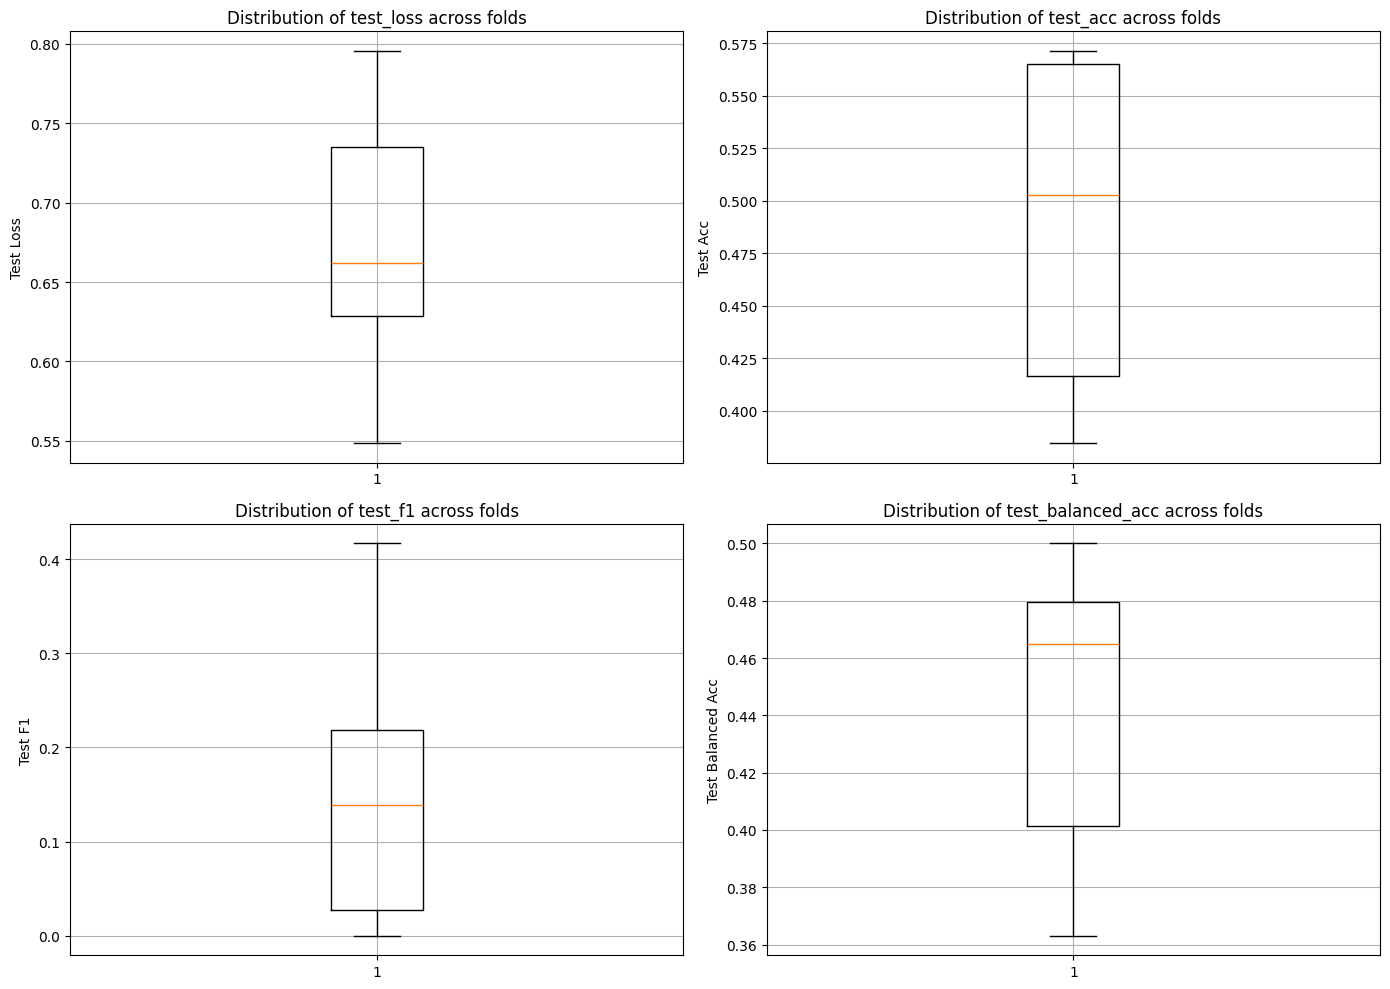

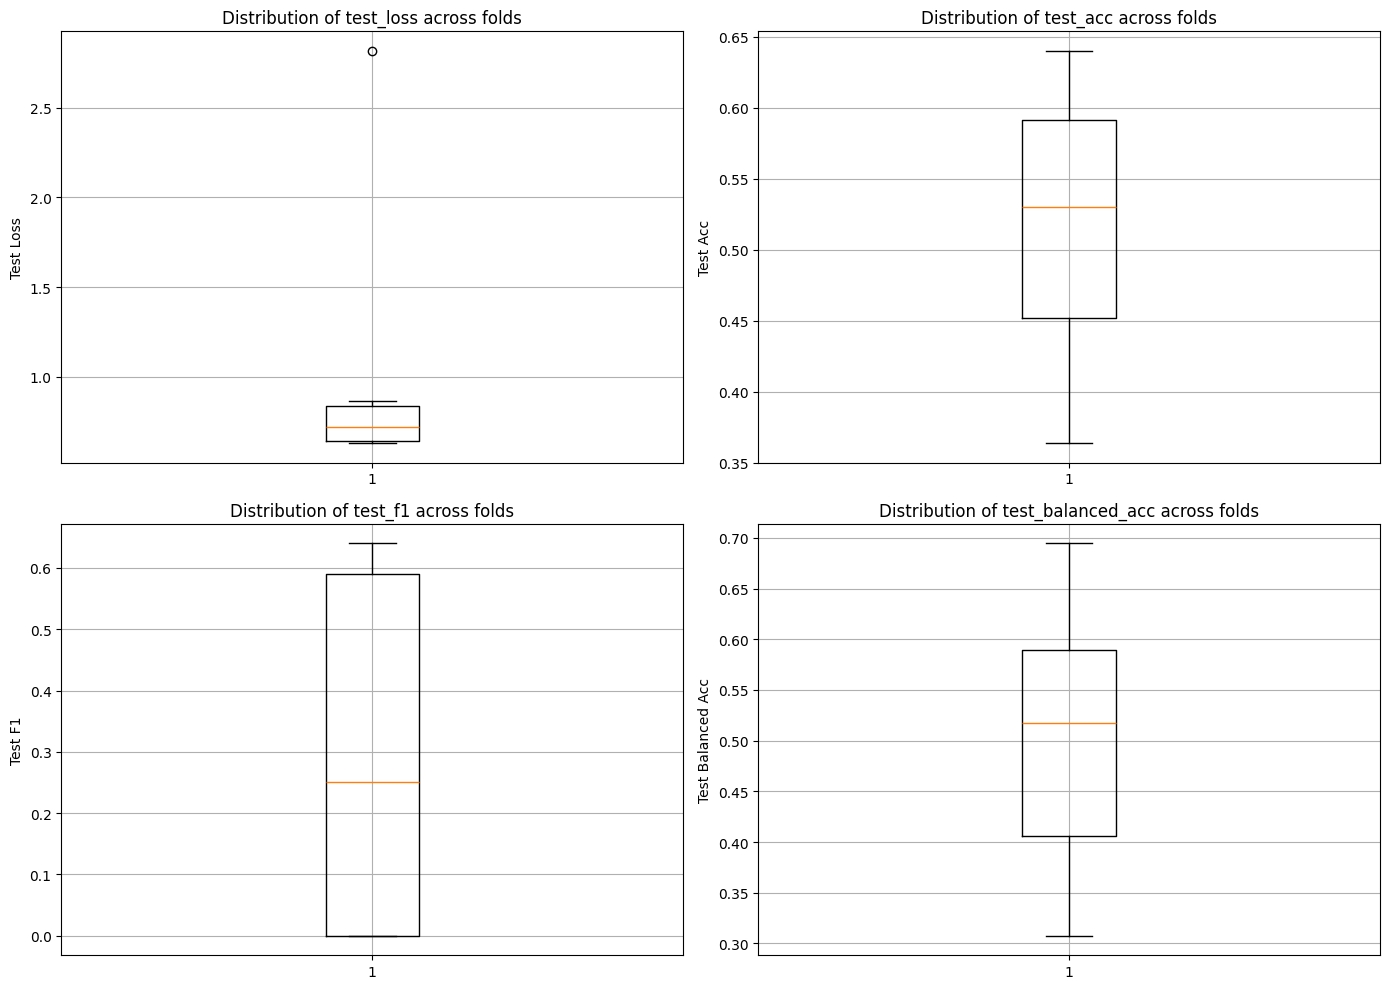

In [46]:
# DOWNSTREAM TASK
import collections
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm # Make sure timm is installed
import torchvision.transforms as T # Assuming you might use torchvision transforms
from utils.train_functions import BaseSSLClassifier, SSLClassifierModule, nested_cv_stratified_by_patient, solve_cuda_oom
import copy
from utils.train_functions import  SSLClassifierModule, get_best_fold_idx
from utils.mlflow_functions import log_SSL_run_to_mlflow

# Import your custom utility functions
from utils.train_functions import MLPClassifierHead, LinearProbeHead # Assuming this defines your classifier head
from utils.train_functions import nested_cv_stratified_by_patient # Your nested CV function
from utils.data_visualization_functions import generate_cv_results_figure # Your plotting function

# --- Configuration ---
MAE_BACKBONE_PATH = SAVE_PATH # Path to your trained MAE weights file
FEATURE_DIM = 768                # Expected output dimension of ViT-Base CLS token (embed_dim)
NUM_CLASSES = 2                  # Number of downstream classes for your specific task
INPUT_SIZE = 224                 # Input image size (HxW) the MAE ViT was pre-trained on and expects

# --- Lightning Module for ViT Fine-tuning ---
class ViTFinetuneModule(pl.LightningModule):
    """
    PyTorch Lightning module specifically for fine-tuning a MAE pre-trained ViT backbone.
    It handles:
    1. Loading the ViT architecture (via TIMM).
    2. Loading the pre-trained MAE backbone weights.
    3. Attaching a classification head (MLP).
    4. Freezing the backbone (optional).
    5. Defining the forward pass, loss, optimizer, and train/val/test steps.
    Designed to be instantiated by the `model_factory` for use with `nested_cv_stratified_by_patient`.
    """
    def __init__(self, mae_weights_path: str,model_name, num_classes: int, freeze_backbone: bool, lr: float):
        """
        Args:
            mae_weights_path (str): Path to the '.pth' file containing MAE backbone weights.
            num_classes (int): Number of target classes for the downstream task.
            freeze_backbone (bool): If True, sets `requires_grad=False` for backbone parameters.
            lr (float): Learning rate for the optimizer.
        """
        super().__init__()
        # Save hyperparameters (num_classes, freeze_backbone, lr) to self.hparams
        # Makes them accessible later (e.g., self.hparams.lr) and logs them automatically.
        # We don't save mae_weights_path as it's used only during init here.
        self.save_hyperparameters("num_classes", "freeze_backbone", "lr")
        # 1. Build ViT Backbone Architecture using TIMM
        # Create the specified ViT model ('vit_base_patch32_224').
        # `pretrained=False`: Do not load ImageNet weights, we'll load MAE weights.
        # `num_classes=0`: Remove the default classifier head from the TIMM model.
        #                  This typically makes the model output the CLS token embedding.
        # print("  Initializing ViT backbone architecture (timm)...")
        vit = timm.create_model(
            model_name=model_name, # Use the model name passed to the constructor
            pretrained=False,
            num_classes=0 # No classifier head, we will add our own later
        )
        self.vit_backbone = vit
        # Get the embedding dimension directly from the loaded TIMM model (robust)
        self.feature_dim = self.vit_backbone.embed_dim
        # print(f"  ViT backbone embedding dimension: {self.feature_dim}") # Should be 768

        # 2. Load MAE Pre-trained Weights into the Backbone
        load_mae_vit_backbone_state_dict(
            model=self.vit_backbone,         # Pass the model instance here
            checkpoint_path=mae_weights_path # Pass the path to the weights file
            # prefix="vit." # Default is "vit.", change if your MAE model used a different internal name
        )

        # 3. Freeze Backbone (Optional)
        # If `freeze_backbone` is True, iterate through backbone parameters and disable gradient calculation.
        if self.hparams.freeze_backbone:
            # print("  Freezing MAE backbone parameters (requires_grad=False).")
            for param in self.vit_backbone.parameters():
                param.requires_grad = False
            # Set the frozen backbone to evaluation mode (disables dropout, uses running stats in BatchNorm if any)
            self.vit_backbone.eval()

        # 4. Attach Classification Head
        # Use the imported MLPClassifierHead utility function.
        # It needs the backbone's output feature dimension (768) and the number of classes.
        # print(f"  Attaching MLPClassifierHead (input_dim={self.feature_dim}, num_classes={self.hparams.num_classes}).")
        #   self.classifier = MLPClassifierHead(self.feature_dim, self.hparams.num_classes)
        self.classifier = LinearProbeHead(self.feature_dim, self.hparams.num_classes)

        # 5. Define Loss Function
        # Standard Cross-Entropy Loss for multi-class classification.
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Defines the forward pass of the model. """
        # Pass input `x` through the ViT backbone.
        # For timm ViTs with num_classes=0, this call typically returns the CLS token embedding.
        # Expected output shape: (batch_size, embed_dim) -> (B, 768)
        features = self.vit_backbone(x)
        # Pass the extracted features (CLS token embedding) through the classifier head.
        logits = self.classifier(features)
        # Return the final logits (raw scores for each class).
        return logits

    def configure_optimizers(self):
        """ Defines the optimizer and optionally learning rate schedulers. """
        # Use AdamW optimizer, common for Transformers.
        # `filter(lambda p: p.requires_grad, self.parameters())`: Ensures only parameters
        # that require gradients (i.e., not frozen) are passed to the optimizer.
        print(f"  Configuring AdamW optimizer with LR={self.hparams.lr}.")
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()),
                                       lr=self.hparams.lr)
        # --- Optional: Add LR Scheduler ---
        # Example: Reduce learning rate when validation loss plateaus
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": {
        #         "scheduler": scheduler,
        #         "monitor": "val_loss", # Metric to monitor for scheduler step
        #         "interval": "epoch",   # Check metric at the end of each epoch
        #         "frequency": 1
        #     },
        # }
        # --- End Optional Scheduler ---
        return optimizer # Return only optimizer if no scheduler is used

    # --- Training, Validation, and Test Steps ---
    # These define the logic executed during the respective phases of training.

    def training_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        """ Performs one step of training. """
        # Assumes batch is a dictionary with 'image' and 'label' keys. Adapt if different.
        images, labels = batch["image"], batch["label"]
        # Get model output (logits) by calling the forward method
        logits = self(images)
        # Calculate the loss
        loss = self.criterion(logits, labels)
        # Calculate accuracy
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        # Log metrics using Lightning's self.log method
        # `on_epoch=True`: aggregates over the epoch. `prog_bar=True`: shows in progress bar.
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True, logger=True)
        return loss # Return the loss tensor

    def validation_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        """ Performs one step of validation. """
        images, labels = batch["image"], batch["label"]
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        # `sync_dist=True`: aggregates metrics correctly across multiple GPUs (if used).
        self.log("val_loss", loss, on_epoch=True, sync_dist=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, sync_dist=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        """ Performs one step of testing. """
        images, labels = batch["image"], batch["label"]
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("test_loss", loss, on_epoch=True, logger=True)
        self.log("test_acc", acc, on_epoch=True, logger=True)
        return loss
# --- Utility Function to Load MAE Weights ---
    
def load_mae_vit_backbone_state_dict(
    model: nn.Module,
    checkpoint_path: str,
    prefix: str = "vit."
) -> None:
    """
    Loads weights from a MAE pre-trained backbone checkpoint into a standard TIMM ViT model.

    Handles the common case where MAE training saves weights with a model-specific
    prefix (e.g., "vit.") which needs to be removed before loading into a base TIMM model.
    It also skips weights that don't belong in the base model (like mask_token or head layers
    if the target model has num_classes=0).

    Args:
        model (nn.Module): The target TIMM ViT model instance (e.g., created with
                           timm.create_model(..., num_classes=0)) into which the
                           weights should be loaded. This model is modified in-place.
        checkpoint_path (str): Path to the .pth file containing the saved state_dict
                               from MAE pre-training (typically model.backbone.state_dict()).
        prefix (str, optional): The prefix expected in the keys of the checkpoint's
                                state_dict that should be removed. Defaults to "vit.".
    """
    # print(f"\n--- Loading MAE Backbone Weights ---")
    # print(f"Target Model Type: {type(model).__name__}")
    # print(f"Loading from Checkpoint: {checkpoint_path}")
    # print(f"Expecting prefix in checkpoint keys: '{prefix}'")

    # --- Load the state dictionary from the file ---
    try:
        # Load to CPU first for flexibility and to avoid GPU memory issues during processing
        checkpoint_state_dict = torch.load(checkpoint_path, map_location="cpu")
        # print(f"  Successfully loaded state dictionary from file.")
    except FileNotFoundError:
        # print(f"  ERROR: Checkpoint file not found at '{checkpoint_path}'. Cannot load weights.")
        # Depending on requirements, you might want to raise the error instead of just printing
        # raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")
        return # Exit the function if file not found
    except Exception as e:
        # print(f"  ERROR: Failed to load checkpoint file '{checkpoint_path}': {e}")
        # raise e
        return # Exit on other loading errors

    # --- Process the loaded state dictionary ---
    processed_state_dict = collections.OrderedDict() # Use OrderedDict to maintain key order potentially
    target_model_keys = set(model.state_dict().keys()) # Get keys expected by the target model

    # print("  Processing checkpoint keys...")
    keys_processed_count = 0
    keys_skipped_prefix = 0
    keys_skipped_mismatch = 0

    for k, v in checkpoint_state_dict.items():
        # Check if the key starts with the expected prefix
        if k.startswith(prefix):
            # Remove the prefix to get the corresponding key in the target model
            new_key = k[len(prefix):]

            # IMPORTANT: Check if this new key actually exists in the target model
            if new_key in target_model_keys:
                processed_state_dict[new_key] = v
                # print(f"    Mapping '{k}' -> '{new_key}'") # Uncomment for detailed debug
                keys_processed_count += 1
            else:
                # This key (e.g., vit.head.weight) exists in the checkpoint but not
                # in the target model (which has num_classes=0). Skip it.
                # print(f"    Skipping key '{k}': Corresponding key '{new_key}' not found in target model.") # Uncomment for detailed debug
                keys_skipped_mismatch += 1
        else:
            # This key doesn't have the prefix. Skip it as it likely belongs to
            # the MAE wrapper (e.g., 'mask_token') or is unexpected.
            # print(f"    Skipping key '{k}': Does not have expected prefix '{prefix}'.") # Uncomment for detailed debug
            keys_skipped_prefix += 1

    # print(f"  Processing complete:")
    # print(f"    {keys_processed_count} keys mapped and kept.")
    # print(f"    {keys_skipped_mismatch} prefixed keys skipped (target mismatch, e.g., head layers).")
    # print(f"    {keys_skipped_prefix} non-prefixed keys skipped (e.g., mask_token).")

    if keys_processed_count == 0:
        # print("  ERROR: No keys were successfully mapped from the checkpoint to the target model!")
        # print("         Please check the `prefix` argument and the checkpoint file contents.")
        return # Exit if no keys were useful

    # --- Load the processed state dictionary into the target model ---
    print("  Attempting to load processed state dictionary into the target model...")
    try:
        # Use strict=True because we expect a perfect match after processing
        missing_keys, unexpected_keys = model.load_state_dict(processed_state_dict, strict=True)

        # These should ideally be empty if processing was correct and strict=True worked
        if missing_keys:
             print(f"  ERROR: Missing keys AFTER processing: {missing_keys}")
        if unexpected_keys:
             print(f"  ERROR: Unexpected keys AFTER processing: {unexpected_keys}")

        if not missing_keys and not unexpected_keys:
             print("  Successfully loaded processed weights into the target model.")

    except Exception as e:
        print(f"  ERROR: Failed to load processed state_dict into model: {e}")
        print(f"         Mapped keys ({len(processed_state_dict)}): {list(processed_state_dict.keys())[:5]}...")
        print(f"         Target keys ({len(target_model_keys)}): {list(target_model_keys)[:5]}...")

    print(f"--- Finished Loading MAE Backbone Weights ---")


# --- Prepare for Nested CV Call ---
# print("\nSetup complete for Nested CV using MAE ViT backbone.")
# print(f"-> Ensure input images are transformed to {INPUT_SIZE}x{INPUT_SIZE}.")
# print(f"-> Ensure classifier MLP head ({type(MLPClassifierHead).__name__}) is defined correctly.")
# print(f"-> Classifier head expects input dimension {FEATURE_DIM}.")

# Define required data transformations for the downstream task.

normalization_params = {
        "subtrahend": [0.485, 0.456, 0.406],
        "divisor": [0.229, 0.224, 0.225],
    }

# **CRITICAL**: Must resize/crop images to INPUT_SIZE (e.g., 224x224).
# **CRITICAL**: Must include normalization (e.g., ImageNet stats) if the ViT expects it.

print(f"Defining example downstream transforms for input size {INPUT_SIZE}x{INPUT_SIZE}...")
from classes.CustomTiffFileReader import CustomTiffFileReader
from monai.transforms import (
    Compose, EnsureTyped, Resized, ScaleIntensityd, NormalizeIntensityd,
    CenterSpatialCropd
)

train_transforms_224 = Compose([
            CustomTiffFileReader(keys=["image"]),
            EnsureTyped(keys=['image', 'label'], data_type="tensor", dtype=torch.float32),
            Resized(keys="image", spatial_size=(224,224), mode='bilinear', size_mode='all'),
            # CenterSpatialCropd(keys="image", roi_size=(224,224)),
            ScaleIntensityd(keys="image"),  # Scale to [0.0, 1.0]
            NormalizeIntensityd(
                keys=["image"],
                subtrahend=normalization_params["subtrahend"] if not CUSTOM_NORMALIZATION else custom_normalization_stats["mean"],
                divisor=normalization_params["divisor"] if not CUSTOM_NORMALIZATION else custom_normalization_stats["std"],
                channel_wise=True
            ),
        ])

val_transforms_224 = Compose([
            CustomTiffFileReader(keys=["image"]),
            EnsureTyped(keys=['image', 'label'], data_type="tensor", dtype=torch.float32),
            Resized(keys="image", spatial_size=(224,224), mode='bilinear', size_mode='all'),
            # CenterSpatialCropd(keys="image", roi_size=(224,224)),
            ScaleIntensityd(keys="image"),  # Scale to [0.0, 1.0]
            NormalizeIntensityd(
                keys=["image"],
                subtrahend=normalization_params["subtrahend"] if not CUSTOM_NORMALIZATION else custom_normalization_stats["mean"],
                divisor=normalization_params["divisor"] if not CUSTOM_NORMALIZATION else custom_normalization_stats["std"],
                channel_wise=True
            ),
            ])

# --- Model Factory Function ---
# This function is designed to be passed to `nested_cv_stratified_by_patient`.
# It creates a fresh instance of the `ViTFinetuneModule` for each call.
for FREEZE_ENCODER in [True,False]:
    # This allows you to toggle freezing the backbone during fine-tuning.
    # Set to False for initial fine-tuning, True for subsequent fine-tuning with frozen backbone.
    # Note: Freezing the backbone is a common practice to stabilize training initially.
    # print(f"  Using freeze_backbone={FREEZE_ENCODER} in model factory.")
    # Note: This is a common practice to stabilize training initially.
    # freeze_backbone = False # Set to True if you want to freeze the backbone during fine-tuning
    def model_factory(lr: float) -> pl.LightningModule:
        """
        Factory function that creates and returns an instance of ViTFinetuneModule.
        Called by the nested CV loop, potentially with different learning rates.

        Args:
            lr (float): The learning rate to use for this specific model instance.

        Returns:
            pl.LightningModule: An initialized ViTFinetuneModule instance.
        """
        print(f"  model_factory called: Creating ViTFinetuneModule instance with LR={lr}")
        # Instantiate the Lightning module, passing necessary arguments.
        # Weight loading happens inside ViTFinetuneModule's __init__.
        model = ViTFinetuneModule(
            mae_weights_path=MAE_BACKBONE_PATH,
            model_name='vit_base_patch32_224',  # Use the same model name as used in MAE pre-training
            num_classes=NUM_CLASSES,
            freeze_backbone=FREEZE_ENCODER,  # Standard practice: start fine-tuning with backbone frozen
            lr=lr                  # Pass the learning rate from the factory argument
        )
        # No need for copy.deepcopy since a new object is created on each call.
        return model

    # --- Execute Nested Cross-Validation ---
    print("\nStarting nested cross-validation...")
    # Replace placeholder variables (df, cfg, labels_np, etc.) with your actual data/config.
    # Make sure these variables are defined before this call.
    # Example placeholder values (replace them!
    # Ensure all required variables are loaded/defined before this call
    if any(x is None for x in [df, cfg, labels_np, pat_labels, unique_pat_ids]):
        print("WARNING: One or more placeholder variables (df, cfg, etc.) are None.")
        print("Skipping nested_cv_stratified_by_patient call.")
    else:
        # per_fold_metrics, fold_results = nested_cv_stratified_by_patient(
        #     df=df,                           # DataFrame with image paths, labels, patient IDs
        #     cfg=cfg,                         # Configuration object
        #     model_factory=model_factory,     # Use the factory returning ViTFinetuneModule
        #     labels_np=labels_np,             # Image-level labels
        #     pat_labels=pat_labels,           # Patient-level labels for outer fold stratification
        #     unique_pat_ids=unique_pat_ids,   # Unique patient IDs corresponding to pat_labels
        #     train_transforms=train_transforms_224, # Pass the 224x224 transforms
        #     val_transforms=val_transforms_224,     # Pass the 224x224 transforms
        #     pretrained_weights=None,         # CRITICAL: Set to None as weights are loaded internally
        #     class_names=class_names,         # List of class names for evaluation/plotting
        #     model_manager=None               # Set to None if not using a separate model manager
        # )
        
        from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
        
        cfg.set_spatial_size((224, 224))  # Set the spatial size in the configuration
        experiment = NestedCVStratifiedByPatient(
            df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
            pretrained_weights=pretrained_weights, class_names=class_names, model_factory=model_factory, num_folds=6,
            compute_custom_normalization=CUSTOM_NORMALIZATION,
            train_transforms=train_transforms_224,
            val_transforms=val_transforms_224,
        )
        # cfg.set_freezed_layer_index(None)
        hold_out_cv = True
        # using_cosine_scheduler = False

        per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()

        #loading the best model for the metric selected, it's then used for computing gradcams during logging
        best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
        model_instance_for_logging, _ = experiment._get_model_and_device()
        model_instance_for_logging.eval()
        try:
            model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
        except FileNotFoundError:
            raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
        except Exception as e:
            raise Exception(f"Error loading model weights: {str(e)}")

        # Now, call the logging function:
        train_transforms, val_transforms,_ = experiment.get_current_fold_transforms()
        # Now, call the logging function:
        # or "moco" if using MoCo
        log_SSL_run_to_mlflow(
            environmentFlags=environment_flags,
            cfg=cfg,
            model=model_factory(0.001),  # Pass a dummy model to log the run
            class_names=class_names,
            fold_results=outer_fold_test_results,
            per_fold_metrics=per_fold_training_metrics,
            hold_out_cv=True,
            test_transforms=val_transforms,
            all_images_paths_np=images_paths_np,
            all_labels_np=labels_np,
            test_images_paths_np=test_images_paths_np,
            test_true_labels_np=test_true_labels_np,
            yaml_path=yaml_path,
            color_transforms=color_transforms,
            model_library=model_library,
            encoder_type= "mae",
            pretrained_backbone_path = MAE_BACKBONE_PATH,
            train_transforms=train_transforms,
            # val_transforms=val_transforms,
            freeze_encoder= FREEZE_ENCODER,
            ssl=True,
        )
        solve_cuda_oom()

### LOADING RANDOM INITIALIZED ENCODER

In [ ]:
from utils.reproducibility_functions import set_global_seed

# Set seed for reproducibility
set_global_seed(42)

In [ ]:
from utils.reproducibility_functions import models_equal_hash
byol_encoder_notPretrained, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
byol_encoder_notPretrained2, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
are_equally_initialized = models_equal_hash(byol_encoder_notPretrained, byol_encoder_notPretrained2)
print(f"Are the two encoders equally initialized? {are_equally_initialized}")

Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
Are the two encoders equally initialized? True
